In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import json

with open('/content/ground_truth.json', 'r') as f:
    data = json.load(f)

images = data['images']
annotations = data['annotations']


apple_counts = {}


for image in images:
    image_id = image['id']

    apple_count = sum(1 for ann in annotations if ann['image_id'] == image_id)
    apple_counts[image['filename']] = apple_count

apple_count_set = {(filename, count) for filename, count in apple_counts.items()}

print(apple_count_set)

{('dataset4_front_480.png', 47), ('dataset2_back_1380.png', 8), ('dataset4_front_390.png', 49), ('dataset3_front_420.png', 31), ('dataset3_back_180.png', 69), ('dataset2_front_1230.png', 43), ('dataset1_back_241.png', 33), ('dataset4_front_1230.png', 43), ('dataset3_front_990.png', 58), ('dataset1_back_991.png', 42), ('dataset2_back_960.png', 2), ('dataset3_front_1260.png', 43), ('dataset2_front_720.png', 4), ('dataset2_front_360.png', 36), ('dataset2_front_300.png', 16), ('dataset2_back_480.png', 28), ('dataset4_front_240.png', 71), ('dataset2_back_30.png', 6), ('dataset3_back_960.png', 48), ('dataset2_front_30.png', 34), ('dataset1_back_961.png', 31), ('dataset4_front_450.png', 42), ('dataset1_front_61.png', 23), ('dataset2_back_750.png', 36), ('dataset3_front_1380.png', 39), ('dataset1_front_781.png', 22), ('dataset3_back_1230.png', 71), ('dataset3_front_210.png', 54), ('dataset1_front_421.png', 30), ('dataset2_back_1110.png', 32), ('dataset3_front_1200.png', 34), ('dataset1_front_1

Image ID: 0, Predicted: 37, True: 31, Error: 6, Accuracy: 0.81
Image ID: 1, Predicted: 15, True: 41, Error: 26, Accuracy: 0.37
Image ID: 2, Predicted: 11, True: 39, Error: 28, Accuracy: 0.28
Image ID: 3, Predicted: 7, True: 32, Error: 25, Accuracy: 0.22
Image ID: 4, Predicted: 7, True: 34, Error: 27, Accuracy: 0.21
Image ID: 5, Predicted: 8, True: 36, Error: 28, Accuracy: 0.22
Image ID: 6, Predicted: 7, True: 37, Error: 30, Accuracy: 0.19
Image ID: 7, Predicted: 8, True: 39, Error: 31, Accuracy: 0.21
Image ID: 8, Predicted: 43, True: 22, Error: 21, Accuracy: 0.05
Image ID: 9, Predicted: 32, True: 22, Error: 10, Accuracy: 0.55
Image ID: 10, Predicted: 40, True: 30, Error: 10, Accuracy: 0.67
Image ID: 11, Predicted: 48, True: 33, Error: 15, Accuracy: 0.55
Image ID: 12, Predicted: 41, True: 37, Error: 4, Accuracy: 0.89
Image ID: 13, Predicted: 34, True: 25, Error: 9, Accuracy: 0.64
Image ID: 14, Predicted: 40, True: 37, Error: 3, Accuracy: 0.92
Image ID: 15, Predicted: 36, True: 30, Error

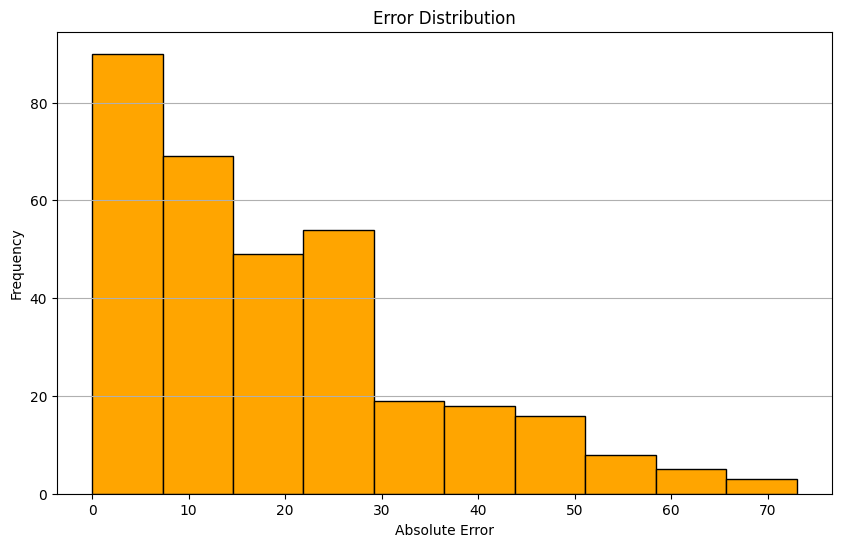

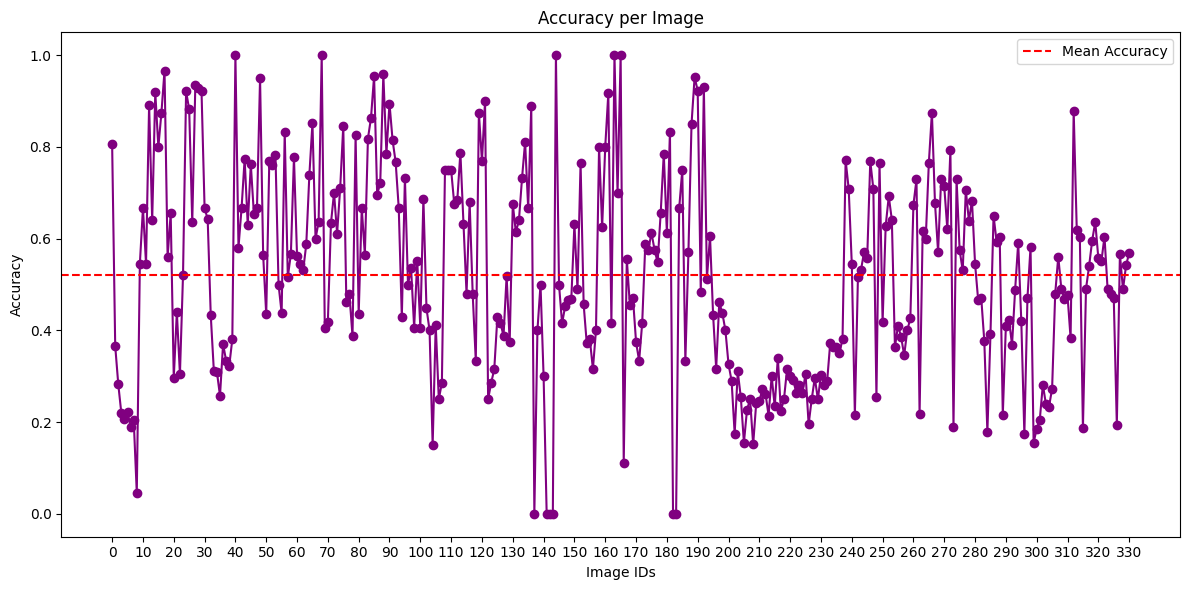

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def count_apples_in_image(image_path):

    image = cv2.imread(image_path)


    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] = cv2.equalizeHist(hsv[:, :, 2])


    hsv = cv2.GaussianBlur(hsv, (7, 7), 0)


    red_low1 = np.array([0, 30, 30])
    red_high1 = np.array([10, 255, 255])
    red_low2 = np.array([160, 30, 30])
    red_high2 = np.array([180, 255, 255])


    mask1 = cv2.inRange(hsv, red_low1, red_high1)
    mask2 = cv2.inRange(hsv, red_low2, red_high2)
    masks = cv2.bitwise_or(mask1, mask2)


    kernel = np.ones((3, 3), np.uint8)
    marker = cv2.morphologyEx(masks, cv2.MORPH_OPEN, kernel, iterations=3)
    marker = cv2.morphologyEx(marker, cv2.MORPH_CLOSE, kernel, iterations=2)


    contours, _ = cv2.findContours(marker, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    apple_count = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 250:
            apple_count += 1

    return apple_count


image_folder = '/content/drive/MyDrive/Counting Apple/images'


true_counts = {filename: count for filename, count in apple_count_set}
image_id_to_filename = {image['id']: image['filename'] for image in images}

predicted_counts = {}
absolute_errors = []

image_accuracies = []

for image_id, filename in image_id_to_filename.items():
    image_path = os.path.join(image_folder, filename)

    predicted_count = count_apples_in_image(image_path)
    predicted_counts[filename] = predicted_count


    true_count = true_counts.get(filename, 0)


    absolute_error = abs(predicted_count - true_count)
    absolute_errors.append(absolute_error)


    if true_count > 0:
        accuracy = max(0, 1 - (absolute_error / true_count))
    else:
        accuracy = 0
    image_accuracies.append(accuracy)

    print(f"Image ID: {image_id}, Predicted: {predicted_count}, True: {true_count}, Error: {absolute_error}, Accuracy: {accuracy:.2f}")


mean_absolute_error = np.mean(absolute_errors)
mean_image_accuracy = np.mean(image_accuracies)


print(f"Mean Absolute Error (MAE): {mean_absolute_error}")
print(f"Mean Image Accuracy: {mean_image_accuracy:.2f}")






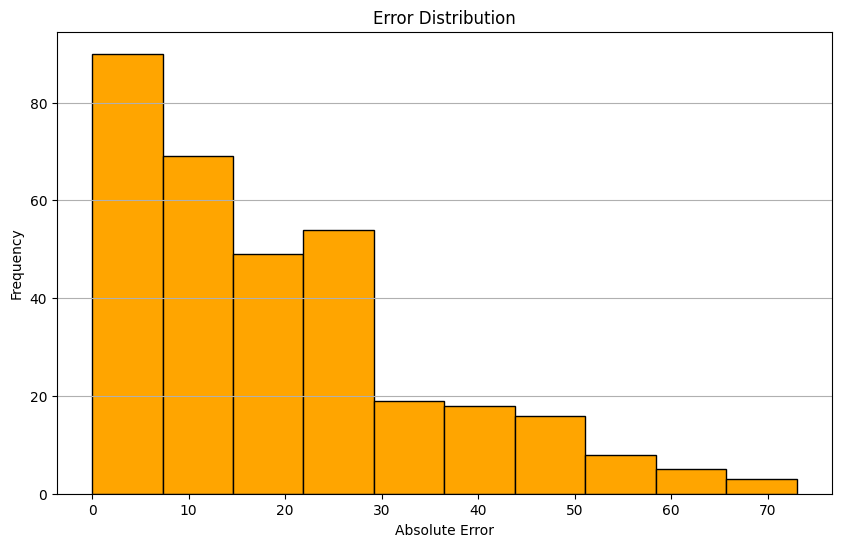

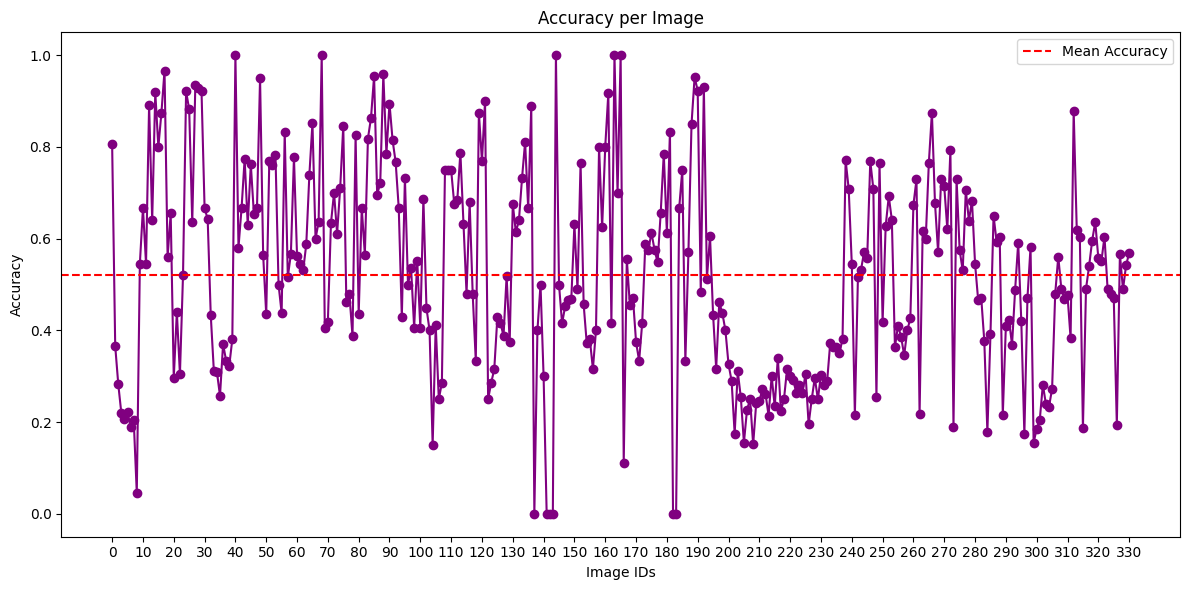

In [8]:

def plot_error_distribution(absolute_errors):
    plt.figure(figsize=(10, 6))
    plt.hist(absolute_errors, bins=10, color='orange', edgecolor='black')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.grid(axis='y')
    plt.show()


def plot_accuracy_per_image(image_accuracies, image_ids):
    plt.figure(figsize=(12, 6))
    plt.plot(image_ids, image_accuracies, marker='o', color='purple')
    plt.axhline(y=np.mean(image_accuracies), color='red', linestyle='--', label='Mean Accuracy')
    plt.xlabel('Image IDs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Image')
    plt.xticks(np.arange(min(image_ids), max(image_ids)+1, 10))
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_error_distribution(absolute_errors)
plot_accuracy_per_image(image_accuracies, list(image_id_to_filename.keys()))